In [21]:
%matplotlib inline

from pathlib import Path
import random
import warnings

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

warnings.filterwarnings(action='ignore')

In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [3]:
WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

In [ ]:
# 재표본추출
# 관찰된 데이터값에서 표본을 반복적으로 추출하는 과정
# 재표본추출에는 부트스트랩과 순열검정이 있음.

# 순열 검정
# 컨트롤 그룹과 처리 그룹의 결과를 하나로 합치고 여기서 무작위로 그룹을 뽑아 가설을 검정함.
# 1. 여러 그룹의 결과를 하나로 결합
# 2. 잘 섞은 후 컨트롤 그룹과 동일한 크기의 표본을 무작위로 (비복원) 추출 (다른 그룹 데이터 포함)
# 3. 나머지 데이터에서 처리 그룹과 동일한 크기의 샘플을 역시 무작위로 비복원 추출.
# 4. 재표본에 대해 통계량을 다시 계산하고 기록
# 5. 이 과정을 N번 반복해 검정통계량의 순열분포를 얻음.
# 6. 그룹간 관찰된 차이가 순열분포 안에 있음 -> 귀무가설 기각 못함.
#    그룹간 관찰된 차이가 대부분 순열분포 밖에 있음 -> 귀무가설

In [4]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

In [5]:
session_times.head(5)

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


Text(0.5, 0.98, '')

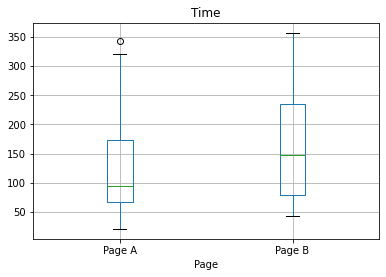

In [7]:
ax = session_times.boxplot(by='Page', column='Time')
plt.suptitle('')

In [8]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


In [19]:
#순열검정

def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

-14.847619047619048


C:\Users\user\AppData\Local\Temp\ipykernel_26540\3877380269.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()
C:\Users\user\AppData\Local\Temp\ipykernel_26540\3877380269.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()


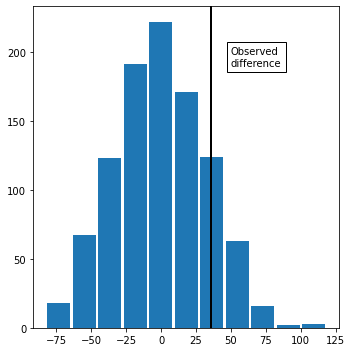

In [23]:
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=mean_b - mean_a, color='black', lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})

plt.tight_layout()
plt.show()

In [25]:
np.mean(perm_diffs > (mean_b - mean_a))
# 페이지 A와 페이지 V 사이의 세션 시간의 차이가 확률분포의 범위내에 있음 >> 차이는 통계적으로 유의하지 않다.

0.139

In [27]:
# p-value
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.496


In [29]:
# 이 경우 가설이 이항분포를 따르기 때문에 순열겁정 없이 p값을 근사할 수 있음.

survivors = np.array([[200, 23739-200], [182, 22588-182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


In [30]:
# t검정

res = stats.ttest_ind(session_times[session_times.Page=='Page A'].Time, 
                     session_times[session_times.Page=='Page B'].Time,
                     equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


In [31]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
    usevar='unequal', alternative='smaller')
print(f'p-value: {pvalue:.4f}')

p-value: 0.1408
